# System

In [1]:
# To show the python version
import sys
assert sys.version_info >= (3,8)
print(sys.version_info)

# to show all the output from a code chunk
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# matplotlib for plotting
from matplotlib import pyplot as plt
%matplotlib inline

# Other external libraries like pandas and numpy
import pandas as pd
import numpy as np
np.random.seed(999)

# machine learning models
import sklearn
print(sklearn.__version__)

#import others
from sklearn.metrics import confusion_matrix
from sklearn import model_selection, datasets
from sklearn.tree import DecisionTreeClassifier
import joblib
import pickle
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

sys.version_info(major=3, minor=10, micro=10, releaselevel='final', serial=0)
1.1.1


# Import Training Data

In [2]:
from scipy.io import arff
# Load the arff file
header_info = arff.loadarff("Dataset/KDDTrain+.arff")
df = pd.DataFrame(header_info[0])
header_names = df.columns.values.tolist()
header_names.append('Difficulty')
kdd_train = pd.read_csv('Dataset/KDDTrain+.txt', delimiter = ',', header = None)

#Rename the headers
kdd_train.columns = header_names


# Data Preprocessing

In [3]:
#Drop the target variables
kdd_train_x = kdd_train.drop(['class', 'Difficulty'], axis = 1)
y = ['class']
kdd_train_y = kdd_train[y]

#Identify categorical features
num_cols = kdd_train_x._get_numeric_data().columns
cate_cols = list(set(kdd_train_x.columns) - set(num_cols))

#One-Hot Encoding the categorical features
cate_features = pd.get_dummies(kdd_train_x[cate_cols], prefix = cate_cols)
one_hot_data = kdd_train_x.drop(cate_cols, axis = 1)
one_hot_data_maha = pd.concat([one_hot_data, cate_features], axis = 1)
one_hot_data_if = one_hot_data_maha
one_hot_data_if.head()
one_hot_data_maha.head()
data_array = np.array(one_hot_data_maha)
data_array.shape    # Make sure that the Numpy array dimension is consistent with the Pandas Dataframe
# function to calculate mahalanobis distance


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


(125973, 122)

In [4]:
label_map = {"normal": 0,
            "neptune": 1,
            "satan": 1,
            "ipsweep": 1,
            "portsweep": 1,
            "smurf": 1,
            "nmap": 1,
            "back": 1,
            "teardrop": 1,
            "warezclient": 1,
            "pod": 1,
            "guess_passwd": 1,
            "buffer_overflow": 1,
            "warezmaster": 1,
            "land": 1,
            "imap": 1,
            "rootkit": 1,
            "loadmodule": 1,
            "ftp_write": 1,
            "multihop": 1,
            "phf": 1,
            "perl": 1, 
            "spy": 1}
kdd_train_y["class_binary"] = kdd_train_y["class"].map(label_map)

C:\Users\khxia\AppData\Local\Temp\ipykernel_10848\3533821117.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kdd_train_y["class_binary"] = kdd_train_y["class"].map(label_map)


# Mahalanobis Distance

In [5]:
import scipy as sp
mu_vec = np.mean(data_array,axis = 0)
inv_cormat = sp.linalg.pinv(np.cov(data_array, rowvar=False))

# For loop to get the distance for all the variables
mahal_dist = []

for i in range(data_array.shape[0]):
    x_minus_mu = data_array[i,:] - mu_vec
    left_term = np.dot(x_minus_mu, inv_cormat)
    mahal = np.dot(left_term, x_minus_mu.T)
    mahal = np.sqrt(mahal)
    mahal_dist.append(mahal)

np.mean(one_hot_data_maha)

from scipy.stats import chi2
one_hot_data_maha['p-value'] = 1 - chi2.cdf(mahal_dist, df = 121) #pdf(x, degreeOfFreedom = Number of Variables)

#Calculate number of p-value less than 0.01
print(np.count_nonzero(one_hot_data_maha['p-value'] < 0.01))


C:\WINDOWS\system32\myenv\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


duration            287.144650
src_bytes         45566.743000
dst_bytes         19779.114421
land                  0.000198
wrong_fragment        0.022687
                      ...     
flag_S1               0.002897
flag_S2               0.001008
flag_S3               0.000389
flag_SF               0.594929
flag_SH               0.002151
Length: 122, dtype: float64

4


In [6]:
mu_vec.shape

(122,)

In [6]:
pvalue = one_hot_data_maha['p-value']

pvalue = np.where(pvalue < 0.01, 1, pvalue)
pvalue = np.where(pvalue >= 0.01, 0, pvalue)

from sklearn.metrics import accuracy_score

train_acc_maha = accuracy_score(kdd_train_y['class_binary'], pvalue)
print("Training accuracy: {:.4f}".format(train_acc_maha))
cm_maha = confusion_matrix (kdd_train_y["class_binary"], pvalue)
print(cm_maha)

Training accuracy: 0.5346
[[67343     0]
 [58630     0]]


Text(0.5, 1.0, 'Seaborn Confusion Matrix with labels\n\n')

Text(0.5, 15.0, '\nPredicted Values')

Text(33.0, 0.5, 'Actual Values ')

[Text(0.5, 0, 'True'), Text(1.5, 0, 'False')]

[Text(0, 0.5, 'True'), Text(0, 1.5, 'False')]

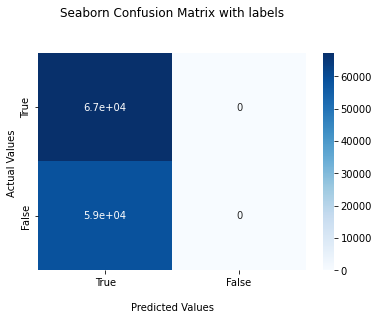

In [7]:
ax = sns.heatmap(cm_maha, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['True','False'])
ax.yaxis.set_ticklabels(['True','False'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Isolation Forest

In [8]:
#Isolation Forest
#from scipy.stats import uniform as sp_randFloat
# from scipy.stats import randint as sp_randInt
from sklearn.ensemble import IsolationForest
model_if = IsolationForest(random_state = 99)
#parameters = {'n_estimators' : sp_randInt(100, 1000),
#            'contamination' : sp_randFloat(0, 1),
#             }
parameters = {'n_estimators' : [100,150,200,250,300],
            'contamination' : np.linspace(0, 0.2, num = 10),
              #'bootstrap': [True, False]
             }
np.linspace(0, 0.3, num = 10)
# def scorer_f(estimator, X):   #Scorer function for isolation forest
#       return np.mean(estimator.score_samples(one_hot_data_if))
from sklearn.metrics import make_scorer, f1_score


#Set normal to 0 and abnormal to 1 (binary)
one_hot_data_if.shape
one_hot_data_if = one_hot_data_if.drop('p-value', axis =1)

# randomly sample
idx_rand = np.random.permutation(len(kdd_train_x))
num_sample = int(0.01*len(kdd_train_x))
one_hot_data_if_sample = one_hot_data_if.iloc[idx_rand[:num_sample]]
kdd_train_y_sample = kdd_train_y.iloc[idx_rand[:num_sample]]


def scorer_f(estimator, X):   #your own scorer
      return np.mean(estimator.score_samples(X))
    
f1sc = make_scorer(f1_score, average = 'micro')
randm_src = RandomizedSearchCV(estimator=model_if, param_distributions = parameters, cv = 3, scoring = f1sc, random_state = 0, return_train_score = True, n_jobs = -1)
model = randm_src.fit(one_hot_data_if_sample, kdd_train_y_sample["class_binary"])

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

from sklearn.datasets import make_classification
XX_train, yy_train = make_classification(n_samples = 500, n_classes=2)
print(yy_train[:20])

rng = np.random.RandomState(42)
#Load the saved isolation Forest model
model_if = joblib.load('IF.sav')
y_pred_if = model_if.predict(one_hot_data_if)
y_pred_if

one_hot_data_if['scores'] = model_if.decision_function(one_hot_data_if)
one_hot_data_if.head()


array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ])

(125973, 123)

C:\WINDOWS\system32\myenv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\WINDOWS\system32\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\WINDOWS\system32\myenv\lib\site-packages\sklearn\ensemble\_iforest.py", line 271, in fit
    raise ValueError(
ValueError: contamination must be in (0, 0.5], got: 0.000000

  warnings.warn(some_fits_failed_message, FitFailedWarning)
C:\WINDOWS\system32\myenv\lib\site-packages\sklearn\model_selectio

 Results from Random Search 

 The best estimator across ALL searched params:
 IsolationForest(contamination=0.044444444444444446, n_estimators=150,
                random_state=99)

 The best score across ALL searched params:
 0.4360836458688488

 The best parameters across ALL searched params:
 {'n_estimators': 150, 'contamination': 0.044444444444444446}
[1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1]


C:\WINDOWS\system32\myenv\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


array([1, 1, 1, ..., 1, 1, 1])

C:\WINDOWS\system32\myenv\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,scores
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0.075292
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0.033050
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0.041132
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0.058326
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0.088731


In [9]:
#Model of Isolation Forest
# model_if = IsolationForest(n_estimators = 150, contamination = 0.044444444444444446, max_features=1.0)
# model_if.fit(one_hot_data_if)


# Train Result (Isolation Forest)

In [10]:
#Evaluation on training result
y_pred_if = np.where(y_pred_if == -1, 0, y_pred_if)

from sklearn.metrics import accuracy_score
train_acc = accuracy_score(kdd_train_y['class_binary'], y_pred_if)
print("Training accuracy: {:.4f}".format(train_acc))

Training accuracy: 0.4259


In [11]:

cm_if = confusion_matrix (kdd_train_y["class_binary"], y_pred_if)
print(cm_if)

[[  882 66461]
 [ 5863 52767]]


Text(0.5, 1.0, 'Seaborn Confusion Matrix with labels\n\n')

Text(0.5, 15.0, '\nPredicted Values')

Text(33.0, 0.5, 'Actual Values ')

[Text(0.5, 0, 'True'), Text(1.5, 0, 'False')]

[Text(0, 0.5, 'True'), Text(0, 1.5, 'False')]

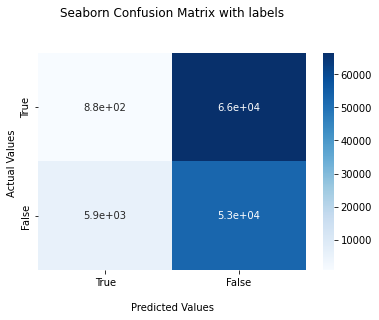

In [12]:
ax = sns.heatmap(cm_if, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['True','False'])
ax.yaxis.set_ticklabels(['True','False'])

## Display the visualization of the Confusion Matrix.
plt.show()

# One Class SVM

In [13]:
one_hot_data_svm = pd.concat([one_hot_data, cate_features], axis = 1)

#10% of data, 12597 out of 125973 is used for training.
one_hot_data_svm_ten_percent = one_hot_data_svm[0:12597]
kdd_train_y_ten_percent = kdd_train_y[0:12597]

from scipy.stats import uniform as sp_randFloat
    #Hyperparameter Tuning
from sklearn.svm import OneClassSVM
parameters_svm = {
             "nu" : sp_randFloat()
             }
model_svm = OneClassSVM()

def scorer_svm(estimator, X):   #Scorer function for OCSVM
      return np.mean(estimator.score_samples(one_hot_data_svm_ten_percent))
    
#Load the saved random_src result
randm_src_svm = joblib.load('OCSVMSearch.sav')


print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src_svm.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src_svm.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src_svm.best_params_)


# svm = OneClassSVM(kernel = 'rbf', gamma = 'scale', nu=0.5488135039273248)



 Results from Random Search 

 The best estimator across ALL searched params:
 OneClassSVM(nu=0.5488135039273248)

 The best score across ALL searched params:
 nan

 The best parameters across ALL searched params:
 {'nu': 0.5488135039273248}


In [14]:
##This is the setting of random search for OCSVM
# randm_src = RandomizedSearchCV(estimator=model_svm, param_distributions = parameters_svm, cv = 5, n_iter = 10, scoring = f1sc, n_jobs=1, random_state=0)
# randm_src.fit(one_hot_data_svm_ten_percent, kdd_train_y_ten_percent)

In [15]:
#Train model with ten percent of data
#Load the saved SVM model
svm = joblib.load('OCSVM.sav')

y_pred_svm = svm.predict(one_hot_data_svm)



C:\WINDOWS\system32\myenv\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [16]:
##This is the original svm.fit
# svm.fit(one_hot_data_svm_ten_percent)

# Train Result (OCSVM)

In [17]:
#Evaluation on training result
y_pred_svm = np.where(y_pred_svm == -1, 0, y_pred_svm)

train_acc = accuracy_score(kdd_train_y['class_binary'], y_pred_svm)
print("Training accuracy: {:.4f}".format(train_acc))

Training accuracy: 0.1468


# Testing

In [18]:
from scipy.io import arff
# Load the arff file
header_info = arff.loadarff("Dataset/KDDTest+.arff")
df = pd.DataFrame(header_info[0])
header_names = df.columns.values.tolist()
header_names.append('Difficulty')
kdd_test = pd.read_csv('Dataset/KDDTest+.txt', delimiter = ',', header = None)

#Rename the headers
kdd_test.columns = header_names

#

In [19]:
#Drop the target variables
kdd_test_x = kdd_test.drop(['class', 'Difficulty'], axis = 1)
y = ['class']
kdd_test_y = kdd_test[y]


In [20]:
combine_data = pd.concat([kdd_train_x, kdd_test_x])

In [21]:
kdd_train_x

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,udp,other,SF,146,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,tcp,private,S0,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,tcp,http,SF,232,8153,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00
125969,8,udp,private,SF,105,145,0,0,0,0,...,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00


In [22]:
combine_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,udp,other,SF,146,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,tcp,private,S0,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,tcp,http,SF,232,8153,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,...,100,141,0.72,0.06,0.01,0.01,0.01,0.00,0.00,0.00
22540,0,tcp,http,SF,317,938,0,0,0,0,...,197,255,1.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00
22541,0,tcp,http,SF,54540,8314,0,0,0,2,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07
22542,0,udp,domain_u,SF,42,42,0,0,0,0,...,255,252,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00


In [23]:

#Identify categorical features
num_cols = combine_data._get_numeric_data().columns
cate_cols = list(set(combine_data.columns) - set(num_cols))

#One-Hot Encoding the categorical features
cate_features = pd.get_dummies(combine_data[cate_cols], prefix = cate_cols)
combine_one_hot_data = combine_data.drop(cate_cols, axis = 1)
combine_one_hot_data = pd.concat([combine_one_hot_data, cate_features], axis = 1)

data_array = np.array(combine_one_hot_data)
data_array.shape    # Make sure that the Numpy array dimension is consistent with the Pandas Dataframe
# function to calculate mahalanobis distance

(148517, 122)

In [24]:
test_one_hot_data = combine_one_hot_data.iloc[125973:,:]

In [25]:
test_one_hot_data

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,protocol_type_icmp,protocol_type_tcp,protocol_type_udp
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,12983,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,1,0,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,794,333,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
22540,0,317,938,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
22541,0,54540,8314,0,0,0,2,0,1,1,...,0,0,0,0,0,1,0,0,1,0
22542,0,42,42,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [26]:
y_pred_if_test = model_if.predict(test_one_hot_data)

C:\WINDOWS\system32\myenv\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [27]:
label_map_test = {"normal": 0,
             "neptune" : 1,
             "guess_passwd" : 1,
             "mscan" : 1,
             "warezmaster" : 1,
             "apache2" : 1,
             "satan" : 1,
             "processtable" : 1,
             "smurf" : 1,
             "back" : 1,
             "snmpguess" : 1,
             "saint" : 1,
             "mailbomb" : 1,
             "snmpgetattack" : 1,
             "portsweep" : 1,
             "ipsweep" : 1,
             "httptunnel" : 1,
             "nmap" : 1,
             "pod" : 1,
             "buffer_overflow" : 1,
             "multihop" : 1,
             "named" : 1,
             "ps" : 1,
             "sendmail" : 1,
             "rootkit" : 1,
             "xterm" : 1,
             "teardrop" : 1,
             "xlock" : 1,
             "land" : 1,
             "xsnoop" : 1,
             "ftp_write" : 1,
             "worm" : 1,
             "loadmodule" : 1,
             "perl" : 1,
             "sqlattack" : 1,
             "udpstorm" : 1,
             "phf" : 1,
             "imap" : 1
          }
kdd_test_y["class_binary"] = kdd_test_y["class"].map(label_map_test)

C:\Users\khxia\AppData\Local\Temp\ipykernel_36368\1644626231.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kdd_test_y["class_binary"] = kdd_test_y["class"].map(label_map_test)


# Isolation Forest

In [28]:
#Evaluation on training result


from sklearn.metrics import accuracy_score

y_pred_if_test = np.where(y_pred_if_test == -1, 0, y_pred_if_test)

test_acc_if = accuracy_score(kdd_test_y["class_binary"], y_pred_if_test)
print("Test accuracy: {:.4f}".format(test_acc_if))

Test accuracy: 0.4994


In [29]:
cm_if = confusion_matrix (kdd_test_y["class_binary"], y_pred_if_test)
print(cm_if)

[[  438  9273]
 [ 2012 10821]]


Text(0.5, 1.0, 'Seaborn Confusion Matrix with labels\n\n')

Text(0.5, 15.0, '\nPredicted Values')

Text(33.0, 0.5, 'Actual Values ')

[Text(0.5, 0, 'True'), Text(1.5, 0, 'False')]

[Text(0, 0.5, 'True'), Text(0, 1.5, 'False')]

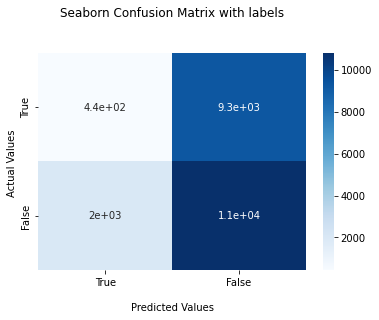

In [30]:


ax = sns.heatmap(cm_if, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['True','False'])
ax.yaxis.set_ticklabels(['True','False'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('IF precision = {:.4f}'.format(precision_score(kdd_test_y["class_binary"], y_pred_if_test)))
print('IF recall = {:.4f}'.format(recall_score (kdd_test_y["class_binary"], y_pred_if_test)))
print('IF f1 score = {:.4f}'.format(f1_score(kdd_test_y["class_binary"], y_pred_if_test)))


IF precision = 0.5385
IF recall = 0.8432
IF f1 score = 0.6573


# OCSVM Test Result

In [32]:
y_pred_svm_test = svm.predict(test_one_hot_data)
y_pred_svm_test = np.where(y_pred_svm_test == -1, 0, y_pred_if_test)

C:\WINDOWS\system32\myenv\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [33]:
test_acc_svm = accuracy_score(kdd_test_y["class_binary"], y_pred_svm_test)
print("Test accuracy: {:.4f}".format(test_acc_svm))

Test accuracy: 0.2347


In [34]:
cm_svm = confusion_matrix (kdd_test_y["class_binary"], y_pred_svm_test)
print(cm_svm)

[[2229 7482]
 [9771 3062]]


In [35]:
print('SVM precision = {:.4f}'.format(precision_score(kdd_test_y["class_binary"], y_pred_svm_test)))
print('SVM recall = {:.4f}'.format(recall_score (kdd_test_y["class_binary"], y_pred_svm_test)))
print('SVM f1 score = {:.4f}'.format(f1_score(kdd_test_y["class_binary"], y_pred_svm_test)))


SVM precision = 0.2904
SVM recall = 0.2386
SVM f1 score = 0.2620


Text(0.5, 1.0, 'Seaborn Confusion Matrix with labels\n\n')

Text(0.5, 15.0, '\nPredicted Values')

Text(33.0, 0.5, 'Actual Values ')

[Text(0.5, 0, 'True'), Text(1.5, 0, 'False')]

[Text(0, 0.5, 'True'), Text(0, 1.5, 'False')]

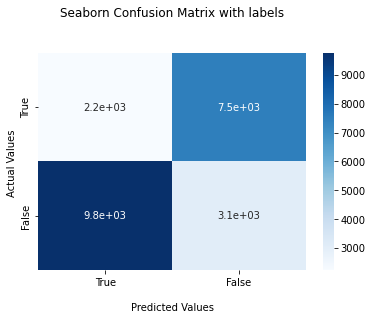

In [36]:
ax = sns.heatmap(cm_svm, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['True','False'])
ax.yaxis.set_ticklabels(['True','False'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Mahalanobis Distance

In [37]:
data_array_test = np.array(test_one_hot_data)

In [38]:
import scipy as sp
mu_vec = np.mean(data_array_test,axis = 0)
inv_cormat = sp.linalg.pinv(np.cov(data_array_test, rowvar=False))

# For loop to get the distance for all the variables
mahal_dist = []

for i in range(data_array_test.shape[0]):
    x_minus_mu = data_array_test[i,:] - mu_vec
    left_term = np.dot(x_minus_mu, inv_cormat)
    mahal = np.dot(left_term, x_minus_mu.T)
    mahal = np.sqrt(mahal)
    mahal_dist.append(mahal)

np.mean(test_one_hot_data)

from scipy.stats import chi2
pvalue = 1 - chi2.cdf(mahal_dist, df = 121) #pdf(x, degreeOfFreedom = Number of Variables)

#Calculate number of p-value less than 0.01
print(np.count_nonzero(pvalue < 0.01))


C:\WINDOWS\system32\myenv\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


duration                218.859076
src_bytes             10395.450231
dst_bytes              2056.018808
land                      0.000311
wrong_fragment            0.008428
                          ...     
flag_SF                   0.659821
flag_SH                   0.003238
protocol_type_icmp        0.046265
protocol_type_tcp         0.837473
protocol_type_udp         0.116262
Length: 122, dtype: float64

0


# Saved Models, RandomSearch Result

In [39]:
ifFile = 'IF.sav'
joblib.dump(model_if, ifFile)

svmFile = 'OCSVM.sav'
joblib.dump(svm, svmFile)
svmSearch = 'OCSVMSearch.sav'
joblib.dump(randm_src_svm, svmSearch)




['IF.sav']

['OCSVM.sav']

['OCSVMSearch.sav']